In [152]:
import json
import numpy as np
import random
import pickle
import re
import colorama
import matplotlib.pyplot as plt
from colorama import Fore, Style
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [153]:

colorama.init()

# === 1. Cargar y Preprocesar Datos === #
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Záéíóúüñ¿?¡!., ]", "", text)  # Solo letras y puntuación
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Cargar datos del archivo JSON
with open('chatbot_data.json') as file:
    data = json.load(file)

# Preprocesamiento de datos
training_sentences = []
training_labels = []
labels = []
responses = []

# Procesar datos
for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(clean_text(pattern))  # Preprocesar texto
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])

    if intent['tag'] not in labels:
        labels.append(intent['tag'])

num_classes = len(labels)


In [154]:
# Codificación de etiquetas
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

# Tokenización y padding
vocab_size = 2000  # Aumentar tamaño del vocabulario
embedding_dim = 50  # Aumentar dimensión de embeddings
max_len = 25
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)


In [155]:

# Reemplazo de la capa de GlobalAveragePooling1D por LSTM
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(LSTM(64, return_sequences=True))  # LSTM capa añadida
model.add(GlobalAveragePooling1D())

# Capas densas con BatchNormalization y Dropout (más agresivo)
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))  # Aumentar el tamaño de las capas densas
model.add(BatchNormalization())
model.add(Dropout(0.7))  # Mayor Dropout para prevenir el sobreajuste

model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.7))  # Mayor Dropout

# Capa de salida
model.add(Dense(num_classes, activation='softmax'))

# Compilación del modelo con tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=0.0001)  # Tasa de aprendizaje más baja
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

model.summary()

# Ajuste de callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  # Paciencia más alta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)  # Reducir lr más rápido

# === 3. Entrenamiento del Modelo === #
history = model.fit(
    padded_sequences,
    np.array(training_labels),
    validation_split=0.2,  # Conjunto de validación al 20%
    batch_size=64,  # Tamaño de lote más grande
    epochs=100,  # Mantener el número máximo de épocas
    callbacks=[early_stop, reduce_lr]
)


c:\Users\Tarda\anaconda3\envs\Canemcat\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_24     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.0000e+00 - loss: 9.61 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.0039 - loss: 9.5024 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.0095 - loss: 9.43 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.0128 - loss: 9.38 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 0.0147 - loss: 9.3583 - val_accuracy: 0.0000e+00 - val_loss: 8.3034 - learning_rate: 1.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0156 - loss: 9.592 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0156 - loss: 9.524 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.0226 - loss: 9.455 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.0248 - loss: 9.404 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.0261 - loss: 9.3742 - val_accuracy: 0.0000e+00 - val_loss: 8.2746 - learning_rate: 1.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0156 - loss: 9.180 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0117 - loss

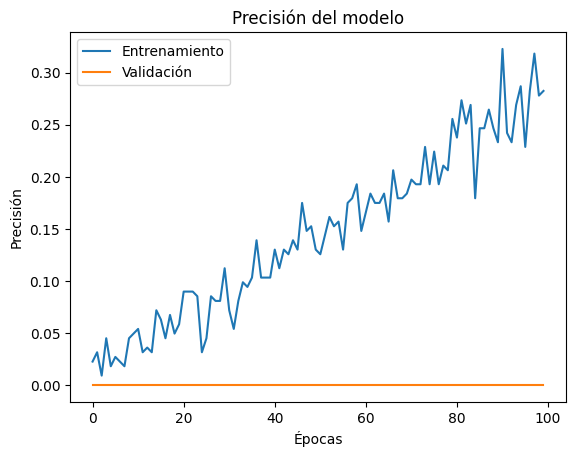

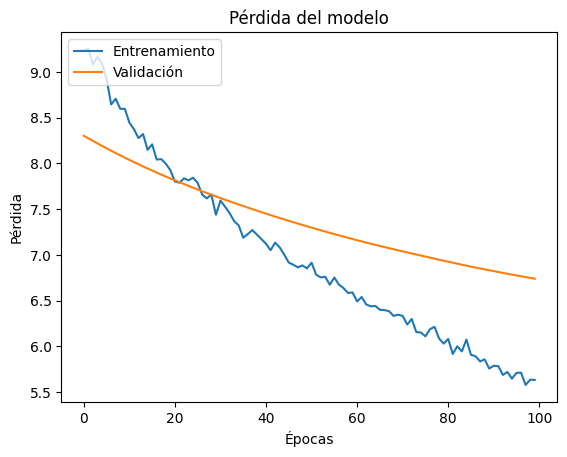

In [156]:
import matplotlib.pyplot as plt

# Graficar la precisión y la pérdida
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()



In [157]:
# === 5. Guardar Modelo y Recursos === #
model.save("chat_model_optimized.h5")
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)


In [158]:
# === 6. Chatbot Interactivo === #
def chat():
    from tensorflow import keras
    model = keras.models.load_model('chat_model_optimized.h5')

    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    max_len = 25
    print(Fore.YELLOW + "¡Empieza a hablar con el bot! (escribe 'quit' para salir)" + Style.RESET_ALL)
    while True:
        print(Fore.LIGHTBLUE_EX + "Usuario: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        # Preprocesar entrada del usuario
        inp_cleaned = clean_text(inp)
        result = model.predict(keras.preprocessing.sequence.pad_sequences(
            tokenizer.texts_to_sequences([inp_cleaned]),
            truncating='post', maxlen=max_len))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])

        for intent in data['intents']:
            if intent['tag'] == tag[0]:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL, random.choice(intent['responses']))
                break

# Iniciar Chatbot
chat()


¡Empieza a hablar con el bot! (escribe 'quit' para salir)
Usuario: 